# 全局设置

In [1]:
# 加载必要的包
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib.colors
import sys
sys.path.append("..")

# 自己写的，Pettitt方法检测时间序列断点
from tools.statistic import plot_pittitt_change_points, Pettitt_change_points, plot_slopes
from tools.statistic import ratio_contribution, plot_ratio_contribution
from tools.processing import get_position_by_ratio

In [2]:
# 绘图全局设置
# %config InlineBackend.figure_format ='retina'
import matplotlib.colors as col
from matplotlib.gridspec import GridSpec
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'out'

period_colors = ['#0889A6', '#F1801F', '#006C43']
region_colors = ["#0077b6", "#e07a5f", "#f2cc8f","#81b29a"]
index_colors = ['#CFA7D1', '#79D6F0', '#E25A53']
index_colormap = matplotlib.colors.ListedColormap(index_colors, 'indexed')
total_water_use_color = '#D1495B'

## 加载数据

In [3]:
# 加载阈值为 0.05的数据，即与黄河流域相交面积大于全市总面积 5% 的所有市
city_yr = pd.read_csv('../data/perfectures/yr/perfectures_in_YR_with_threshold_0.05.csv')

# 非直接用水比例

## 方法介绍

间接用水比例（Indirect Proportion of Water Use）来指示供水优先性，用于描述被消耗的水资源中，以间接形式惠益于人类的部分。

计算方法：
$$ I_{P} = \frac{WU_{non-pro}}{WU_{pro} + WU_{non-pro}} $$

其中i是年份，indirect和direct分别是为人类间接带来惠益的取用水方式和带来直接惠益取用水方式

indirect包括： 
- 工业用水量（IND），每年用于工业目的的取水量，包括自给自足的工业和与公共供水网络连接的工业。
- 城市服务业用水量（Urban service WU），指公共供水网络每年用于服务活动的直接用水量。

direct包括：
- 农业灌溉用水总量（IRR）：每年抽取的灌溉用水量，包括运输和田间施用期间的损失，但不包括牧场或水产养殖用水
- 城市居民用水（Urban domestic WU）：公共供水网络每年用于城镇居民直接取水的水量
- 农村居民用水（Rural domestic WU）：公共供水网络每年用于农村居民和牲畜直接使用的取水量
- 农村牲畜用水（Rural livestock WU）：公共供水网络用于牲畜饮水和清洁的年度取水量

In [4]:
# 产生直接惠益的用水方式
direct = ['IRR', 'Urban domestic WU', 'Rural domestic WU', 'Rural livestock WU']

# 产生间接惠益的用水方式
undirect = ['IND', 'Urban service WU']

# 间接用水量
undirect_water_use = city_yr.groupby('Year').sum()[undirect]

# 总用水量
total_water_use = city_yr.groupby('Year').sum()['Total water use']
 
# 整个流域的间接惠益用水占比
priority = undirect_water_use.sum(axis=1) / total_water_use

# 计算贡献
undirect_water_use.columns = ["Industry", "Service"]
priority_contributions = ratio_contribution(numerator=undirect_water_use, denominator=total_water_use)

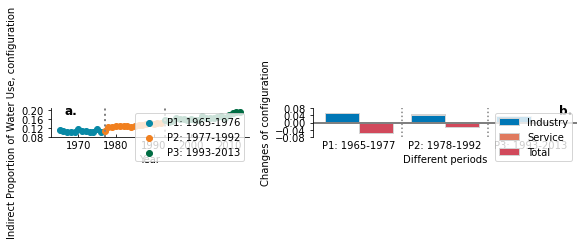

In [5]:
# 绘图
fig = plt.figure(figsize=(8, 3), constrained_layout=True)
gs = GridSpec(1, 2, figure=fig, width_ratios=[3, 4])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

# 绘制图1
plot_pittitt_change_points(priority, change_points=[1977, 1993], ax=ax1, colors=period_colors)

# 绘制图2
plot_ratio_contribution(priority_contributions,
                        ax=ax2,
                        colors=region_colors,
                        denominator_color=total_water_use_color,
                        denominator_label='Total')

# 修饰图1
ax1.set_ylabel("Indirect Proportion of Water Use, configuration")
ax1.set_xlabel("Year")
ax1.set_yticks(np.arange(0.08, 0.21, 0.04))
ax1.set_ylim(0.08, 0.21)
ax1.text(1968, 0.2, 'a.', ha='center', va='center', weight='bold', size='large')

# 修饰图2
ax2.set_xlabel("Different periods")
ax2.set_ylabel("Changes of configuration")
ax2.tick_params(axis='x', tickdir='in', bottom=False, labelrotation=0)
ax2.axhline(0., lw=2, color='gray')
ax2.set_ylim(-0.08, 0.08)
ax2.set_yticks(np.arange(-0.08, 0.081, 0.04))
ax2.axvline(1.5, ls=':', color='gray', lw=1.5)
ax2.axvline(0.5, ls=':', color='gray', lw=1.5)
ax2.text(2.4, 0.065, 'b.', ha='center', va='center', weight='bold', size='large')

# 调整坐标轴显示
for ax in [ax1, ax2]:
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)

# 出图
plt.show();

# 配水指数

## 方法介绍

模仿熵的公式，我们设计了一个衡量分配平均度的指标“配水指数(Water Distribution Index, WDI)”。我们假设最平均的水分配情况是，为每个行政区域某个部门分配到的用水量，都等于全流域该部门的平均用水比例。但实际上区域有别，有的区域会更集中发展某个用水部门，这就导致了水的分配不够平均，使得分配熵增大。而实际的分配情况与假设的平均分配情况，即为配水指数WDI，**WDI越大代表分配越平均，越小代表分配越不均匀**

![entropy](https://gitee.com/SongshGeo/PicGo_picbed/raw/master/img/diagram_water_distribution_index.jpg)

例如在上图中，左边展示的是假设的区域间均匀分配的情况。后者则是实际中分工各有差异，发展各有先后的情况。

我们使用 Configuration Entropy Metric $CEM$ 来表达这种配置上的均匀性

$$ CEM = \sum_{i=1}^n -log(p_{i}) * p_{i} $$

其中$i$ 代表配置水资源的单位（区域 or 部门） $p_i$ 代表了其中一个单位$i$分到水的比例。
对不同区域来说，当水资源完全平均分配，即对任意区域$i$，都有$p_i = 1/n $时，$Entropy$取最大值：

$$ CEM_{max} = \sum_{i=1}^n -log(p_{i}) * p_{i} = - log(\frac{1}{n}) $$

可见，$CEM$ 指标度量的是水资源配置“不均匀”的程度，类似于信息熵是对“混乱程度”的度量，即参与分配的各个单位之间，分配比例差距越大，则熵越小。
而我们的指标应反映随着社会发展，水资源配置在区域之间更加均衡（比例差距小）、整体满足不同用水部门的发展需求（比例差距减小）、但不同区域存在部门分工（比例差距增大）的趋势。

因此，用$CEM_r$代表流域各区域间的CEM，$CEM_s$代表流域各部门间的CEM, $CEM_{rs}$代表区域各部门间的CEM（详见附录）我们获得了表征流域用水配置的指标$I_C$：

$$ I_C = \frac{CEM_{r}*CEM_{s}}{CEM_{rs}}$$


### 配置熵指标：补充材料部分
衡量水资源配置的指标$I_C$由三部分水资源配置熵指标（CEM）构成：

$$ I_C = \frac{CEM_{r}*CEM_{s}}{CEM_{rs}}$$

(1) 描述区域间水资源配置的 $CEM_r$：

$$ CEM_r = \sum_{i=1}^4 -log(p_{i}) * p_{i} $$

其中$p_i$是区域$i$（$i=1$ to $4$ 分别代表 SR, UR, MR, or, DR）的水资源使用量（$WU_i$）在所有区域水资源消耗总量中所占的比例，即:

$$ p_i = \frac{WU_i}{\sum_{i=1}^4 WU_i} $$

(2) 描述部门间水资源配置的 $CEM_s$:

$$ CEM_s = \sum_{j=1}^3 -log(p_{j}) * p_{j} $$

其中$p_j$是用水部门$j$（$j=1$ to $3$ 分别代表 agriculture, industry, domestic and services）的水资源使用量（$WU_j$）在所有部门水资源消耗总量中所占的比例，即:

$$ p_j = \frac{WU_j}{\sum_{j=1}^3 WU_j} $$


(3) 描述区域各部门间水资源配置分工的 $CEM_{rs}$:

$$ CEM_{rs} = \frac{1}{3} * \sum_{j=1}^3 \sum_{i=1}^4 -log(p_{ij} * p_{ij})$$

其中$p_{ij}$是区域$i$在部门$j$上的用水$WU_{ij}$占所有区域在部门$j$上总用水的比例，即：

$$ p_{ij} = \frac{WU_ij}{\sum_{i=1}^4 WU_ij} $$

In [6]:
# 各区域每年的总用水
wu_cols = ['IRR', 'IND', 'DOM']
city_yr['DOM'] = city_yr['RUR'] + city_yr['URB']  # 人居耗水
region_consumption = city_yr.groupby(['Year', 'Region'])[wu_cols].sum()  # 每个区域的总耗水量

results = {}
for yr in city_yr['Year'].unique():
    
    data = region_consumption.loc[yr].replace(0., 0.0000000001)  # 有一些数值为0的数据，填补为很小
    # 区域之间的指数
    region_p = data.sum(axis=1) / data.sum().sum()  # 每个区域分到的水资源比例
    region_entropy = np.sum(- region_p * np.log(region_p))  # 区域之间分配水资源的熵
    
    # 对每个区域：将各部门的用水量换算成比率 p，计算每个区域不同用水部门之间分配的熵，再取各个区域的均值
    section_entropy = (
        data
        .apply(lambda row: row/row.sum(), axis=0)  # 某个行业上用的水，在各个区域之间的分配比例
        .apply(lambda row: row.apply(lambda p: -p*np.log(p)).sum(), axis=0)  # 每一列计算熵（同行业在不同区域之间的分配均匀性）
        .mean()  # 再全流域（四个区域之间）平均
    )
    section_max_p = data.sum() / data.sum().sum()  # 每个行业的耗水比例
    section_max_entropy = section_max_p.apply(lambda p: -p*np.log(p)).sum()  # 每个行业，全流域的平均分配比例上
    section_index = section_entropy / section_max_entropy
 
    # 区域的指数 / 部门的指数
    index_ratio = region_entropy / section_index

    results[yr] = {
        'Regions': region_entropy,
        'Divisions': section_entropy,
        'Sectors': section_max_entropy,
        'Ratio': index_ratio,
    }
    
index_result = pd.DataFrame(results).T

entropy_contributions = ratio_contribution(numerator=index_result[['Sectors', 'Regions']], denominator=index_result['Divisions'])

# Configuration
configuration = index_result['Ratio']

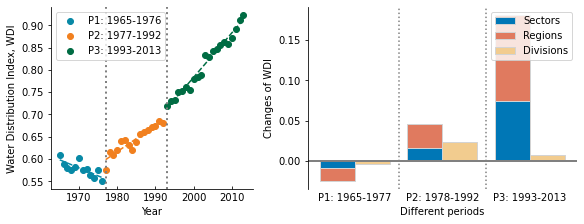

In [7]:
# 绘图
fig = plt.figure(figsize=(8, 3), constrained_layout=True)
gs = GridSpec(1, 2, figure=fig, width_ratios=[3, 4])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

# 绘图ax1
configuration_slopes = plot_pittitt_change_points(index_result['Ratio'], change_points=[1977, 1993], ax=ax1, colors=period_colors)
# 绘图ax2
plot_ratio_contribution(entropy_contributions, denominator_color=region_colors[2], denominator_label="Divisions", ax=ax2)

# 修饰图1
ax1.set_ylabel("Water Distribution Index, WDI")
ax1.set_xlabel("Year")
# ax1.set_yticks(np.arange(0.28, 0.62, 0.10))
# ax1.set_ylim(0.28, 0.64)
# ax1.text(1998, 0.60, 'a.', ha='center', va='center', weight='bold', size='large')

# 修饰图2
ax2.set_xlabel("Different periods")
ax2.set_ylabel("Changes of WDI")
ax2.tick_params(axis='x', tickdir='in', bottom=False, labelrotation=0)
ax2.axhline(0., lw=2, color='gray')
ax2.axvline(1.5, ls=':', color='gray', lw=1.5)
ax2.axvline(0.5, ls=':', color='gray', lw=1.5)
# ax2.text(2.4, 0.140, 'b.', ha='center', va='center', weight='bold', size='large')

# 调整坐标轴显示
for ax in [ax1, ax2]:
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)

# 出图
plt.show();

# SFV结构性缺水指数

## 方法介绍

人类利用科技手段不断的管理水资源，因此简单的物理缺水指数无法合理评估结构性水资源短缺在社会-水系统演化与过渡中所起的作用。因此，我们参考 Qin et al., 2019中提出的结构性缺水指数来评价流域缺水。该指数考虑了修建水库等管理措施，以及用水结构变化对水资源短缺情况评价的影响。

利用该方法指示水资源压力$I_S$，认为全流域的水资源压力是各区域SFV指数的均值，即：

$$ I_S = \frac{1}{4} * \sum_{i=1}^4 SFV_{i} $$

而计算某区域$i$的SFV指数，需要考虑三个权重相等的方面，标准化后计算SFV指数：
$$ SFV_i = a * V_i + b $$
$$ V_i = \frac{A_{i, normalize} + B_{i, normalize} + C_{i, normalize}}{3} $$
$$ a = \frac{1}{V_{max} - V_{min}}; $$
$$ b = \frac{1}{V_{min} - V_{max}} * V_{min} $$

（注：原文献中使用的常数为100，得到的指数结果位于$0~100$之间，这里为了和其余两指数保持$0~1$的相同数量级，将该系数调整为1）
- 首先是总的耗水量占区域多年平均径流量的比例：
$$ A_{i, j} = \frac{WU_{i,j}}{R_{i, avg}} $$

其中平均径流量用如下公式计算：
$$ R_{i, avg} = \frac{1}{j} * \sum_{j=1}^j R_{i} $$

- 其次是非弹性用水量占多年平均径流量的比例：
$$ B_{i, j} = \frac{WU_{inflexible}}{R_{i, avg}} $$

对于非弹性用水，Qin在文章中给出了如下划分：
For inflexible consumption, we include (according to Qin et al., 2019):    
- (1) Freshwater consumed for irrigation of perennial crops.
- (2) Water  evaporated during cooling of thermal power plants. √
- (3) Water evaporated from reservoirs.
- (4) Basic water allotments for humans and livestock. √

由于数据限制，本研究中，取其中（2）、（4）的和为非弹性用水。

- 最后，还要考虑水库的库容能力及调蓄作用对应对天然径流波动的积极影响：
$$ C1_{i, j} = \frac{R_{i, std}}{R_{i, avg}} $$

$$ C2_{i} = \frac{RC_{i}}{R_{i, avg}}, \ if RC < R_{i, avg} $$

$$ C2_{i} = 1, \ if RC >= R_{i, avg} $$

$$ C_i = C1_i * (1 - C2_i) $$

其中$RC_i$是该区域的水库总库容，$R_{i, std}$是多年径流的标准差，衡量天然径流的波动。

Qin, Y. et al. Flexibility and intensity of global water use. Nature Sustainability 2, 515–523 (2019).

In [8]:
# 加载径流和水库数据
use_cols = {
    '唐乃亥': 'SR',  # 唐乃亥控制源区
    '头道拐': 'UR',  # 头道拐控制上游
    '花园口': 'MR',  # 花园口控制中游
    '利津': 'DR'     # 利津控制下游
}
measured_runoff = pd.read_csv(r'../data/hydrology/1956-2016_runoff.csv', index_col='年份')
measured_runoff = measured_runoff.loc[:, use_cols.keys()]
measured_runoff.rename(use_cols, axis=1, inplace=True)

In [9]:
# 水库库容数据
reservoirs_capacity = pd.read_csv(r'../data/hydrology/cum_reservoirs.csv',
                                  index_col=0)

# 水库库容累积相加数据
reservoirs_capacity_cumulating = reservoirs_capacity.cumsum()

In [10]:
## 提取非灵活用水的数据

# 与基本信息有关的列
use_cols = ['Year', 'Region', 'City_ID']

# 与耗水量有关的列
wu_cols = [
    'Total water use',
    'IRR', 'IND', 'RUR', 'URB', 
    'Urban domestic WU', 'Rural domestic WU', 
    'Rural livestock WU', 'Urban service WU',
    'Industrial gross value added (GVA): Thermal electrivity',
    'Industrial WUI: Thermal electrivity'
]

# 不具备弹性的用水类别
inflexible_wu = [
    'Urban domestic WU',
    'Rural domestic WU',
    'Rural livestock WU',
    'Thermal WU'  # 需要用 Thermal 的 WUI 和 GVA 相乘进行计算
]

use_cols.extend(wu_cols)  # 在计算SFV中所有使用的数据列

# 加载所有使用的数据
consumptions = city_yr[use_cols].copy()

# 计算火电冷却用水的量
consumptions['Thermal WU'] = consumptions['Industrial gross value added (GVA): Thermal electrivity'] * consumptions['Industrial WUI: Thermal electrivity']
consumptions.drop(wu_cols[-2:], axis=1, inplace=True)  # 删除计算后的 WUI, GVA 数据

for col in consumptions.columns:
    if col in wu_cols or col in inflexible_wu:
        consumptions[col] = consumptions[col] * 10   # 转化单位 km3 → 10^8 m3

consumptions.head()

,Year,Region,City_ID,Total water use,IRR,IND,RUR,URB,Urban domestic WU,Rural domestic WU,Rural livestock WU,Urban service WU,Thermal WU
0,1965,UR,C27,3.285860,3.005177,0.117663,0.090214,0.072806,0.053977,0.058185,0.032029,0.018829,0.004365
1,1966,UR,C27,3.519960,3.235953,0.119966,0.090686,0.073354,0.054876,0.057330,0.033356,0.018478,0.003637
2,1967,UR,C27,3.724324,3.400632,0.172264,0.080629,0.070799,0.053929,0.046496,0.034134,0.016870,0.010638
3,1968,UR,C27,3.914576,3.526895,0.224933,0.088092,0.074656,0.056472,0.053221,0.034871,0.018184,0.015332
4,1969,UR,C27,4.061363,3.657395,0.197515,0.120128,0.086325,0.063396,0.084373,0.035755,0.022929,0.008404


## 计算三部分指数

In [11]:
## 计算三个部分的指数

# A 总耗水量 / 平均多年径流量
total_water_use = consumptions.groupby(['Region', 'Year']).sum()['Total water use']

regions = ['SR', 'UR', 'MR', 'DR']

index_a = pd.DataFrame()
for region in regions:
    a = total_water_use.loc[region] / measured_runoff.mean(axis=0)[region]
    index_a[region] = a
    
    
# B 总不灵活耗水量 / 平均多年径流量
inflexible_water_use = consumptions.groupby(['Region', 'Year']).sum()[inflexible_wu].sum(axis=1)

index_b = pd.DataFrame()
for region in regions:
    b = inflexible_water_use.loc[region] / measured_runoff.mean(axis=0)[region]
    index_b[region] = b
    
# C1
index_c1 = measured_runoff.std() / measured_runoff.mean()

# C2
index_c2 = pd.DataFrame()
for region in regions:
    avg_runoff = measured_runoff[region].mean()
    c2 = reservoirs_capacity_cumulating[region].apply(lambda x: x/avg_runoff if x < avg_runoff else 1)
    index_c2[region] = c2
    
# C
index_c = (1-index_c2) * index_c1

## 标准化

In [12]:
# 标准化数据
def normalization_horizontal(data):
    sfv = pd.DataFrame(columns=[regions])
    for row in data.itertuples():
        year = row[0]
        value = np.array(row[1:])
        avg = np.mean(value)
        std = np.std(value)
        sfv.loc[year] = (value - avg) / std
    return sfv


# 新建空的 sfv_index 数据框，准备存储数据
use_years = city_yr['Year'].unique()
v_values = np.zeros(index_a.shape)
for index in [index_a, index_b, index_c]:
    index = normalization_horizontal(index.loc[use_years].copy())
    v_values += index.values / 3
    

# 将V-values使用 SFV = a * V + b 转化为 SFV_index
sfv_values = []
for v_row in v_values:
    a = 1 / (v_row.max() - v_row.min())
    b = 1 * v_row.min() / (v_row.min() - v_row.max())
    sfv = a * v_row + b
    sfv_values.append(sfv)

# 计算区域的SFV指数
sfv_regions = pd.DataFrame(sfv_values, columns=regions, index=use_years)

# 计算全域的平均SFV指数
sfv = pd.Series(np.array(sfv_values).mean(axis=1), index=use_years)

## 非灵活用水占比

In [13]:
inflexible_water_use = consumptions.groupby(['Year']).sum()[inflexible_wu]
inflexible_water_use_sum = inflexible_water_use.sum(axis=1)
total_water_use = consumptions.groupby(['Year']).sum()['Total water use']

# 非灵活用水占比
inflexible_ratio = inflexible_water_use_sum / total_water_use

# 非灵活用水贡献
inflexible_contributions = ratio_contribution(numerator=inflexible_water_use, denominator=total_water_use)

## SFV的三部分贡献

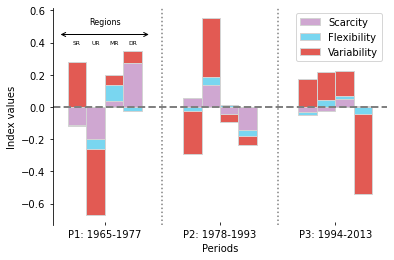

In [14]:
def get_index_yr(start_yr, end_yr):
    differences = []
    for index in [index_a, index_b, index_c]:
        data = normalization_horizontal(index)
        differences.append((data.loc[end_yr] - data.loc[start_yr])/3)
    return differences

sfv_contribution = pd.DataFrame()
sfv_contribution = sfv_contribution.append(get_index_yr(1965, 1977))
sfv_contribution = sfv_contribution.append(get_index_yr(1978, 1993))
sfv_contribution = sfv_contribution.append(get_index_yr(1994, 2013))

# ================================== 作图 =============================
fig, ax = plt.subplots()

def sfv_contribution_plot(ax):
    width = 0.16
    alpha = 1
    for i in range(3):
        data = sfv_contribution.iloc[i*3:i*3+3]  # 数据
        period = "P{}".format(i+1)  # 哪个阶段
        bottoms_pos = [0, 0, 0, 0]  # 正方向的底
        bottoms_neg = [0, 0, 0, 0]  # 反方向的底
        for j, row in enumerate(data.itertuples(index=False)):
            index = ["Scarcity", "Flexibility", "Variability"][j]
            color = ['#CFA7D1', '#79D6F0', '#E25A53'][j]
            for d, height in enumerate(row):
                region = ['SR', 'UR', 'MR', 'DR'][d]
                position = i - 1.5 * width + d * width
                if j == 0 and i == 0:
                    ax.text(position, 0.4, region, size=6, va="center", ha="center")
                if height >= 0:
                    bottom = bottoms_pos[d]
                    if d == 1 and i == 1:
                        ax.bar(x=position, height=height, bottom=bottom, width=width, color=color, alpha=alpha, edgecolor='lightgray', label=index)
                    else:
                        ax.bar(x=position, height=height, bottom=bottom, width=width, color=color, alpha=alpha, edgecolor='lightgray')
                    bottoms_pos[d] += height
                else:
                    bottom = bottoms_neg[d]
                    if d == 1 and i == 1:
                        ax.bar(x=position, height=height, bottom=bottom, width=width, color=color, alpha=alpha, edgecolor='lightgray', label=index)
                    else:
                        ax.bar(x=position, height=height, bottom=bottom, width=width, color=color, alpha=alpha, edgecolor='lightgray')
                    bottoms_neg[d] += height
    ax.legend()
    ax.axhline(y=0, ls="--", lw=2, color='gray')
    ax.axvline(1.5, ls=':', color='gray')
    ax.axvline(0.5, ls=':', color='gray')
    ax.set_ylabel("Index values")
    ax.set_xticks(np.arange(0, 2.1, 1))
    ax.set_xlabel("Periods")
    ax.set_xticklabels(["P1: 1965-1977", "P2: 1978-1993", "P3: 1994-2013"])

    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['right'].set_visible(False)

    ax.text(0, 0.5, "Regions", va='bottom', ha='center', size=8)
    ax.annotate("", xy=(-0.4, 0.45), xycoords='data',
             xytext=(0.4, 0.45), textcoords='data',
             arrowprops=dict(arrowstyle="<->",
                             connectionstyle='arc3'))

sfv_contribution_plot(ax)
plt.show();

### 非灵活用水贡献

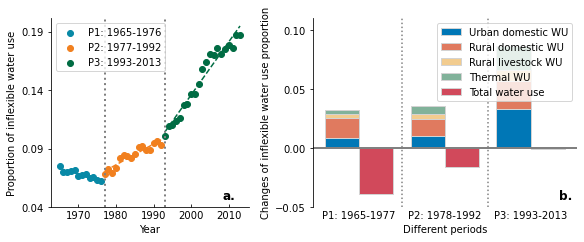

In [15]:
# 绘图
fig = plt.figure(figsize=(8, 3.25), constrained_layout=True)
gs = GridSpec(1, 2, figure=fig, width_ratios=[3, 4])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

# 绘制图片 1
inflexible_slopes = plot_pittitt_change_points(inflexible_ratio, change_points=[1977, 1993], colors=period_colors, ax=ax1)

# 绘制图片 2
plot_ratio_contribution(inflexible_contributions, denominator_color=total_water_use_color, denominator_label='Total water use', ax=ax2)

# 修饰图片 1
ax1.set_xlabel("Year")
ax1.set_ylabel("Proportion of inflexible water use")
ax1.set_yticks(np.arange(0.04, 0.20, 0.05))
ax1.legend(loc=2)
ax1.text(2010, 0.05, 'a.', ha='center', va='center', weight='bold', size='large')

# 修饰图片 2
ax2.set_xlabel("Different periods")
ax2.set_ylabel("Changes of inflexible water use proportion")
ax2.axvline(1.5, ls=':', color='gray', lw=1.5)
ax2.axvline(0.5, ls=':', color='gray', lw=1.5)
ax2.axhline(0., lw=2, color='gray')
ax2.set_yticks(np.arange(-0.05, 0.11, 0.05))
ax2.set_ylim(-0.05, 0.11)
ax2.text(2.4, -0.04, 'b.', ha='center', va='center', weight='bold', size='large')
ax2.tick_params(axis='x', tickdir='in', bottom=False, labelrotation=0)

# 调整坐标轴显示
for ax in [ax1, ax2]:
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

# 出图
# plt.savefig('../figures/sup/inflexible_wu.pdf', dpi=300)
# plt.savefig('../figures/sup/inflexible_wu.jpg', dpi=300)
plt.show();

# 综合耦合指数

我们认为水资源利用制度，与水资源利用的三个维度紧密相关：
- 用水压力（stress, S）
- 用水优先性（configuration, P）
- 用水配置（priority, C）

根据经验，我们认为这三者与社会发展$(Dev.)$具有方向性关系:

- 社会的发展通常伴随着用水向社会经济系统倾斜，用水方式优先向收益更高的非供给性方式倾斜：
$$ Dev \propto P $$
- 社会发展通常伴随着更具结构性的水资源配置，如区域部门之间的分工合作，以及区域的统筹配置：
$$ Dev \propto C $$ 
- 可持续的社会发展应该通过技术手段有效缓解发展过程中产生的水资源压力，才能实现可持续发展：
$$ Dev \propto S^{-1} $$

将三者合一起，即：
$$ Dev. \propto P*C*S^{-1} $$

在上述假设的基础上，我们要构建流域综合耦合指数(Integrated Water Resources Utilization, IWRU)，使 IWRU 有效表征与用水相关的三个维度。首先为每个维度选择一个合适的指示因子（indicator, $I_x$, 其中$x=P, C or S$）。将上式进行自然对数转换，从而让三个维度之间变成加减关系：
$$ Dev. \propto ln(I_P) + ln(I_C) - ln(I_S) $$

然后为了给定 IWRU 确定的值域，同时让三个维度之间等权重，对三者进行标准化处理，得到我们的综合耦合指数 IWRU：
$$ IWRU = norm(ln(I_P)) + norm(ln(I_C)) - norm(ln(I_S)) $$

In [16]:
# 设置探索断点的显著性阈值
p_shr = 0.0005

# 计算全域耦合指数
def zscore(x):
    return (x-x.min())/(x.max()-x.min())

# 第二种 Z-score 标准化方法，对断点无影响
# def zscore(x):
#     average = x.mean()
#     stddev = x.std()
#     return (x-average)/stddev


# # 第三种 [-1, 1] 之间的标准化，也对断点无影响
# def zscore(x):
#     return (x-x.mean())/(x.max()-x.min())

norm_priority, norm_configuration, norm_sfv = zscore(np.log(priority)), zscore(np.log(configuration)), zscore(np.log(sfv))

# 计算 IWRU 指数
iwru = norm_priority + norm_configuration - norm_sfv  # iwru 是三者的 norm_score 相加再相减

## Fig.3 三元图

对三元图来说，计算的是每个维度 $X$ 对 regime 的影响（Impact）

$$ Impact_X = \frac{I'_X}{\sum_X I'_X} $$

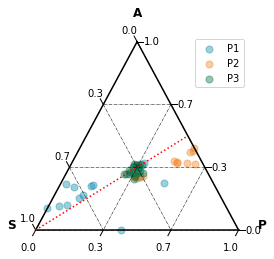

In [17]:
# 制作三元图
points = []
points_1, points_2, points_3 = [], [], []
size_1, size_2, size_3 = [], [], []
scale = 50
for yr in configuration.index:
    sumed = norm_priority[yr] + norm_configuration[yr] + norm_sfv[yr]  # 这里点的大小是三者 norm_score 相加
    point = (norm_priority[yr]/sumed, norm_configuration[yr]/sumed, norm_sfv[yr]/sumed)
    points.append(point)
    if yr < 1978:
        points_1.append(point)
        size_1.append(sumed * scale)
    elif yr < 1993:
        points_2.append(point)
        size_2.append(sumed * scale)
    else:
        points_3.append(point)
        size_3.append(sumed * scale)

# 如果没有ternary包，就 uncommand 下面一行进行安装
# pip install python-ternary
import ternary
fig, ax = plt.subplots(figsize=(4, 4))
figure, tax = ternary.figure(ax=ax, scale=1)
tax.boundary()
tax.gridlines(ls="-.", multiple=1./3, color="black")
# Plot a few different styles with a legend
tax.scatter(points_1, marker='o', color=period_colors[0], label="P1", s=scale, alpha=.4)
tax.scatter(points_2, marker='o', color=period_colors[1], label="P2", s=scale, alpha=.4)
tax.scatter(points_3, marker='o', color=period_colors[2], label="P3", s=scale, alpha=.4)
# tax.plot(points, ls=':', lw='0.7')   # 各点之间的连接线
fontsize = 12
offset = 0.15

tax.ticks(axis='brl', multiple=1./3, linewidth=1, tick_formats="%.1f", offset=0.03)
# tax.ticks(axis='l', clockwise=True, multiple=1./3, linewidth=1, tick_formats="%.1f", offset=0.03)
tax.get_axes().axis('off')
tax.clear_matplotlib_ticks()

def get_point(yr):
    a = norm_priority[yr] + norm_configuration[yr] - norm_sfv[yr]
    return (norm_priority[yr]/a, norm_configuration[yr]/a, norm_sfv[yr]/a)

tax.set_axis_limits((0,1))
tax.line((0,0,1),(.5,.5,0), ls=":", color='red')
tax.right_corner_label("P", fontsize=fontsize, offset=0.25, weight='bold')
tax.top_corner_label("A", fontsize=fontsize, offset=0.25, weight='bold')
tax.left_corner_label("S", fontsize=fontsize, offset=0.25, weight='bold')

tax.legend()
tax.savefig("../figures/main/phases.jpg", dpi=300)
tax.savefig("../figures/main/phases.pdf", dpi=300)
tax.show();

In [18]:
pd.DataFrame(points_3).mean(axis=0)

0    0.329116
1    0.318723
2    0.352160
dtype: float64

## 计算贡献度

首先是计算各个指标（$I_x, x = P, S, or C$）的贡献度：

$$ IWRU = I'_P + I'_C - I'_S $$

对每个起始年份为$y1$，截止年份为$y2$的时间段，有：

$$ \Delta IWRU = IWRU_{y2} - IWRU_{y1} $$

即：

$$ \Delta IWRU = (I'_{P_{y2}} + I'_{C_{y2}} - I'_{S_{y2}}) - (I'_{P_{y1}} + I'_{C_{y1}} - I'_{S_{y1}}) = \Delta I'_P + \Delta I'_C + (-\Delta I'_S) $$

则每个指标$x$ ($P$, $C$, or $S$)对IWRU变化量的贡献度$Contribution_x$为：

$$ Contribution_x = \frac{\Delta I'_x}{|\Delta IWRU|} $$

其影响是：

$$ Impact_X = \frac{\Delta I'_X}{\sum_X |\Delta I'_X|} $$

In [19]:
# 计算每个阶段的贡献度

index_list = ['Tendentiousness', 'Pattern', 'Stress']  # 数据集字典的键
contribution = {index: [] for index in index_list}  # 用于储存贡献率计算结果的字典
periods = []  # 用于储存时间段划分的空列表
changes = {}  # 储存每个时间段的变化

# 寻找断点
breakpoints = Pettitt_change_points(iwru, p_shr=p_shr)
change_points = breakpoints.copy()
change_points.extend([iwru.index.max(), iwru.index.min()])  # 为断点增加头尾
check_points = sorted(change_points.copy())  # 排序好的断点列表作为检查点

# 循环，每两个断点之间算一个阶段，计算每个阶段不同指数的贡献率。
for i in range(len(check_points)-1):
    j = i + 1
    start_year = check_points[i]
    end_year = check_points[j]
    if end_year in breakpoints:
        end_year = end_year - 1
    period = 'P{}: {}-{}'.format(j, start_year, end_year)
    periods.append(period) # 每个阶段的标准化格式

    # 计算 iwru 总的变化
    changes[period] = abs(iwru.loc[end_year] - iwru.loc[start_year])
    iwru_change = iwru[end_year] - iwru[start_year]

    # 再计算三个分指标的变化
    priority_change = norm_priority[end_year] - norm_priority[start_year]
    configuration_change = norm_configuration[end_year] - norm_configuration[start_year]
    sfv_change = norm_sfv[start_year] - norm_sfv[end_year]

    # 计算变化的贡献率并存入结果字典
    contribution['Tendentiousness'].append(100 * priority_change / abs(iwru_change))
    contribution['Pattern'].append(100 * configuration_change / abs(iwru_change))
    contribution['Stress'].append(100 * sfv_change / abs(iwru_change))

# 将结果转化为 DataFrame 并返回
contribution = pd.DataFrame(contribution, index=periods)

# 贡献度，IWRU变化
contribution
changes


# 变化贡献
changes_contribution = pd.DataFrame()
for col in contribution:
    changes_contribution[col] = contribution[col] * pd.Series(changes) / 100

In [20]:
a = changes_contribution['Stress'].iloc[0]
b = changes_contribution['Stress'].iloc[1]

(b - a)/a

-1.8885467661704272

## 最终作图

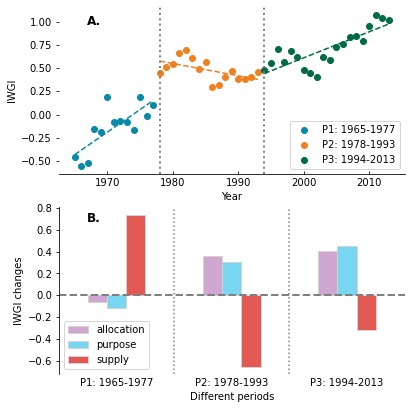

In [21]:
# 绘图
fig = plt.figure(constrained_layout=False, figsize=(6, 6))
fig.subplots_adjust(left=0.15, right=0.95, top=.95, bottom=.10)

gs = GridSpec(2, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
# ax2 = fig.add_subplot(gs[0, 2])
ax3 = fig.add_subplot(gs[1, :])

wcci_slopes = plot_pittitt_change_points(iwru, ax=ax1, colors=period_colors, p_shr=p_shr)
# plot_slopes(wcci_slopes, ax=ax2, colors=period_colors)
changes_contribution.columns = ['allocation', 'purpose', 'supply']
changes_contribution.plot.bar(ax=ax3, colormap=index_colormap, edgecolor='lightgray')

# 修饰图片1
ax1.set_xlabel('Year')
ax1.set_ylabel('IWGI')
# ax1.set_ylim(0.04, 0.105)
# ax1.set_yticks(np.arange(0.04, 0.105, 0.02))
ax1.text(1968, 1.0, 'A.', ha='center', va='center', weight='bold', size='large')
ax1.legend(loc=4)

# 修饰图片2
# ax2.set_xlabel("Slope")
# ax2.set_xticklabels([.0, .5, 1])
# ax2.text(-0.006, 2.2, 'B.', ha='center', va='center', weight='bold', size='large')

# 修饰图片3
ax3.set_xlabel("Different periods")
ax3.set_ylabel('IWGI changes')
for tick in ax3.get_xticklabels():  # 旋转角度
    tick.set_rotation(0)  # 轴标签旋转
ax3.axhline(y=0, c='gray', lw=2, ls="--")
# ax3.set_yticks(np.arange(-0.01, 0.021, 0.01))
ax3.tick_params(axis='x', tickdir='in', bottom=False, labelrotation=0)
ax3.text(-0.2, 0.7, 'B.', ha='center', va='center', weight='bold', size='large')
ax3.axvline(1.5, ls=':', color='gray')
ax3.axvline(0.5, ls=':', color='gray')

# 调整坐标轴显示
for ax in [ax1, ax3]:
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['right'].set_visible(False)

ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(False)

# 储存和显示图片
plt.savefig('../figures/main/index.pdf', dpi=300)
plt.savefig('../figures/main/index.jpg', dpi=300)
plt.show();

In [22]:
changes_contribution
for index in ["supply", "allocation", "purpose"]:
    index
    changes_contribution[index] / changes_contribution.sum(axis=1)

print("\n如果算贡献率的话：")
for index in ["supply", "allocation", "purpose"]:
    index
    changes_contribution[index].abs() / changes_contribution.abs().sum(axis=1) 


如果算贡献率的话：


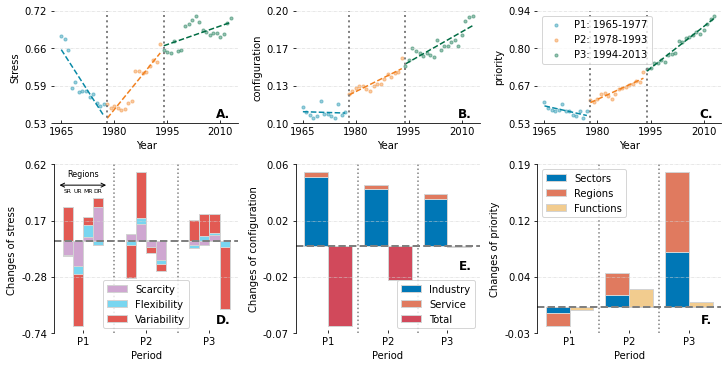

In [23]:
fig = plt.figure(figsize=(10, 5), constrained_layout=True)

gs = GridSpec(2, 3, figure=fig, height_ratios=[2, 3])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[1, 0])
ax5 = fig.add_subplot(gs[1, 1])
ax6 = fig.add_subplot(gs[1, 2])


import matplotlib.ticker as ticker
size = 10
alpha= 0.4

sfv_slopes = plot_pittitt_change_points(sfv, change_points=[1978, 1994], colors=period_colors, ax=ax1, s=size, alpha=alpha, legend=False)
priority_slopes = plot_pittitt_change_points(priority, change_points=[1978, 1994], colors=period_colors, ax=ax2, s=size, alpha=alpha, legend=False)
configuration_slopes = plot_pittitt_change_points(configuration, change_points=[1978, 1994], colors=period_colors, ax=ax3, s=size, alpha=alpha, legend=False)

ax1.set_ylabel("Stress")
ax2.set_ylabel("configuration")
ax3.set_ylabel("priority")
for ax in [ax1, ax2, ax3]:
    ax.set_xlim(1963, 2015)
    ax.set_xticks(np.arange(1965, 2015, 15))
    ax.set_xlabel("Year")
ax3.legend(loc=2)


# =========== 各个贡献 =============== #


sfv_contribution_plot(ax4)
plot_ratio_contribution(
    priority_contributions,
    ax=ax5,
    colors=region_colors,
    denominator_color=total_water_use_color,
    denominator_label='Total',
    legend_loc='lower right'
)
plot_ratio_contribution(
    entropy_contributions, 
    denominator_color=region_colors[2], 
    denominator_label="Functions", 
    ax=ax6,
    legend_loc='upper left'
)

# 修饰图片

for ax in [ax5, ax6]:
    ax.set_xlabel("Different periods")
    # ax.set_ylabel("Changes of inflexible water use proportion")
    ax.axvline(1.5, ls=':', color='gray', lw=1.5)
    ax.axvline(0.5, ls=':', color='gray', lw=1.5)
    ax.axhline(0., lw=2, color='gray', ls="--")
    # ax.set_yticks(np.arange(-0.05, 0.11, 0.05))
    # ax.set_ylim(-0.05, 0.11)
    # ax.text(2.4, -0.04, 'b.', ha='center', va='center', weight='bold', size='large')
    ax.tick_params(axis='x', tickdir='in', bottom=True, labelrotation=0)

    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

for ax in [ax1, ax2, ax3]:
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)

for ax in [ax4, ax5, ax6]:
    ax.set_xticklabels(["P1", "P2", "P3"])
    ax.set_xlabel('Period')

ax4.legend(loc='lower center')
ax4.set_ylabel("Changes of stress ")
ax5.set_ylabel("Changes of configuration")
ax6.set_ylabel("Changes of priority")


labels = ["A.", "B.", "C.", "D.", "E.", "F."]
for i, ax in enumerate([ax1, ax2, ax3, ax4, ax5, ax6]):
    ax.set_yticks(np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 4))
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    ax.yaxis.grid(color='lightgray', linestyle='-.', linewidth=0.5)
    x, y = get_position_by_ratio(ax, 0.92, 0.08)
    if i == 4:
        x, y = get_position_by_ratio(ax, 0.92, 0.4)
    ax.text(x, y, labels[i], ha='center', va='center', weight='bold', size='large')

# plt.savefig("../figures/main/dimensions.pdf", dpi=300)
# plt.savefig("../figures/main/dimensions.jpg", dpi=300)
plt.show();

## 对阈值变化的敏感性分析

Text(0, 0.5, 'Number of the breakpoints')

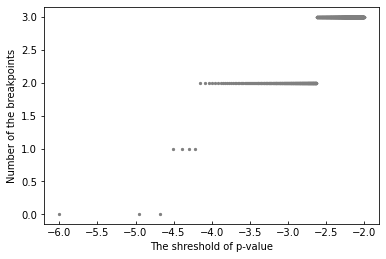

In [24]:
from tools.statistic import Pettitt_change_points
fig, ax = plt.subplots()
x = np.linspace(0.000001, 0.01, 1000)
y = []
for p in x:
    periods = Pettitt_change_points(iwru, p_shr=p)
    y.append(len(periods))

ax.scatter(np.log10(x), y, color='gray', s=5)
ax.set_xlabel("The shreshold of p-value")
ax.set_ylabel("Number of the breakpoints")

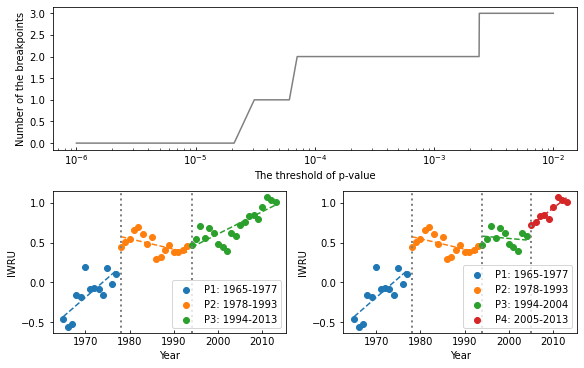

In [25]:
# 绘图
fig = plt.figure(constrained_layout=True, figsize=(8, 5))
# fig.subplots_adjust(left=0.15, right=0.95, top=.95, bottom=.10)

gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

ax1.semilogx(x, y, color='gray')
ax1.set_xlabel("The threshold of p-value")
ax1.set_ylabel("Number of the breakpoints")

for ax in [ax2, ax3]:
    ax.set_xlabel("Year")
    ax.set_ylabel("IWRU")
    
plot_pittitt_change_points(iwru, ax=ax2, p_shr=0.001)
plot_pittitt_change_points(iwru, ax=ax3, p_shr=0.01)

plt.savefig("../figures/sup/sensitivity.pdf", dpi=300)
plt.show();

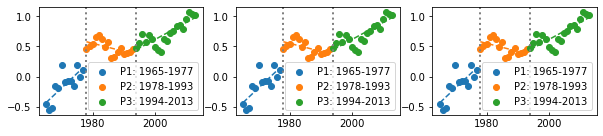

In [26]:
fig, axs = plt.subplots(1, 3, figsize=(10, 2))
p_shrs = [0.0001, 0.0003, 0.0005]
for i, p_shr in enumerate(p_shrs):
    plot_pittitt_change_points(iwru, ax=axs[i], p_shr=p_shr)
plt.show();

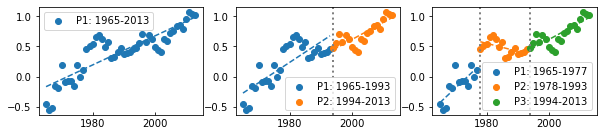

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(10, 2))
p_shrs = [0.00001, 0.00005, 0.0001]
for i, p_shr in enumerate(p_shrs):
    plot_pittitt_change_points(iwru, ax=axs[i], p_shr=p_shr)
plt.show();

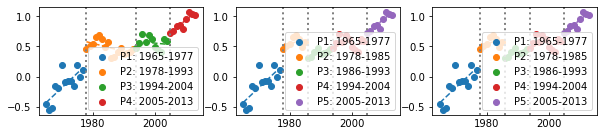

In [28]:
fig, axs = plt.subplots(1, 3, figsize=(10, 2))
p_shrs = [0.01, 0.02, 0.03]
for i, p_shr in enumerate(p_shrs):
    plot_pittitt_change_points(iwru, ax=axs[i], p_shr=p_shr)
plt.show();